## Updating collection schema

We discussed the challenges with updating a profile schema in the last lesson.

The same applies for collections!

We want the ability to update the collection with new memories as well as update existing memories in the collection.

Now we'll show that [Trustcall](https://github.com/hinthornw/trustcall) can be also used to update a collection.

This enables both addition of new memories as well as [updating existing memories in the collection](https://github.com/hinthornw/trustcall?tab=readme-ov-file#simultanous-updates--insertions
).

Let's define a new extractor with Trustcall.

As before, we provide the schema for each memory, `Memory`.  

But, we can supply `enable_inserts=True` to allow the extractor to insert new memories to the collection.

In [1]:
from langchain_groq import ChatGroq
import os
from dotenv import load_dotenv

load_dotenv()
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
model = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct", temperature=0.5)

In [2]:
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [3]:
from pydantic import BaseModel, Field
class Memory(BaseModel):
    """This is the memory field where store the collection of user data like his interested, his name, and so one. in one word all about the user info."""
    content: str = Field(description="The main content of the memory. User expressed interested in learning Programming.")

In [4]:
from trustcall import create_extractor

trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True,
    
)



In [5]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# Instruction
instruction = """Extract memories from the following conversation:"""

# Conversation
conversation = [HumanMessage(content="Hi, I'm Al Amin"),
                AIMessage(content="Nice to meet you, Al Amin."),
                HumanMessage(content="This morning I had a nice bike ride in Dhaka.")]


result = trustcall_extractor.invoke(
    {
        "messages": [SystemMessage(content=instruction)]+conversation
    }
)

In [6]:
for m in result['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_0vdr)
 Call ID: call_0vdr
  Args:
    content: Al Amin had a nice bike ride in Dhaka.


In [7]:
for m in result['responses']:
    print(m.model_dump())

{'content': 'Al Amin had a nice bike ride in Dhaka.'}


In [8]:
for m in result['response_metadata']:
    print(m)

{'id': 'call_0vdr'}


### **Update the memory**

In [9]:
# Update the conversation
updated_conversation = [AIMessage(content="That's great, did you do after?"),
                        HumanMessage(content="I went to Tartine and ate a croissant."),
                        AIMessage(content="What else is on your mind?"),
                        HumanMessage(content="I was thinking about my Japan, and going back this winter!"),]

# Update the instruction
system_msg = """Update existing memories and create new ones based on the following conversation:"""

In [10]:
## Extracting the existing memory.
tool_name = "Memory"
existing_memories = [(str(i), tool_name, memory.model_dump()) for i, memory in enumerate(result['responses'])] if result['responses'] else None
existing_memories

[('0', 'Memory', {'content': 'Al Amin had a nice bike ride in Dhaka.'})]

In [11]:
## Update the memory
result = trustcall_extractor.invoke(
    {
        "messages": updated_conversation,
        "existing": existing_memories
    }
)

In [12]:
# Messages from the model indicate two tool calls were made
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_g64z)
 Call ID: call_g64z
  Args:
    content: Al Amin had a nice bike ride in Dhaka. He then went to Tartine and ate a croissant. He was thinking about Japan and going back this winter.


In [13]:
for m in result["responses"]:
    print(m)

content='Al Amin had a nice bike ride in Dhaka. He then went to Tartine and ate a croissant. He was thinking about Japan and going back this winter.'


In [14]:
# Metadata contains the tool call
for m in result["response_metadata"]:
    print(m)

{'id': 'call_g64z'}


# ***Chatbot with collection schema Updating***

In [15]:
from IPython.display import Image, display

import uuid

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.memory import InMemoryStore
from langchain_core.messages import merge_message_runs
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore

# Memory schema
class Memory(BaseModel):
    """The main content of the memory. For example: User expressed interest in learning about French."""
    
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about Programming.")

# Create the Trustcall extractor
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    # This allows the extractor to insert new memories
    enable_inserts=True,
)

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful chatbot. You are designed to be a companion to a user.

You have a long term memory which keeps track of information you learn about the user over time.

Current Memory (may include updated memories from this conversation):

{memory}"""

# Trustcall instruction
TRUSTCALL_INSTRUCTION = """Reflect on following interaction.

Use the provided tools to retain any necessary memories about the user.

Use parallel tool calling to handle updates and insertions simultaneously:"""

In [16]:
def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memories from the store and use them to personalize the chatbot's response."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memories", user_id)
    memories = store.search(namespace)
    
    # Format the memories for the system prompt
    info = "\n".join(f"- {mem.value['content']}" for mem in memories)
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=info)
    
    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""

    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]
    
    namespace =("memories", user_id)
    
    ## Retrieve the recent memory content
    existing_items = store.search(namespace)
    
    
    # Format the existing memories for the Trustcall extractor
    tool_name = "Memory"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )
    
    ## update the prompt
    update_messages = list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION)]+state['messages']))
    
    ## invoke the extractor
    result = trustcall_extractor.invoke(
        {
            "messages": update_messages,
            'existing': existing_memories
        }
    )
    
    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )

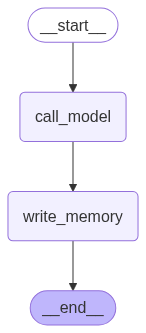

In [17]:
# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [18]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input
input_messages = [HumanMessage(content="Hi, my name is Al Amin")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Al Amin
================================== Ai Message ==================================

Nice to meet you, Al Amin! I've added your name to my memory. I'll make sure to address you by name in our future conversations. How are you doing today? Is there something I can help you with or would you like to chat?


In [19]:
# User input
input_messages = [HumanMessage(content="I like to Programming and want to leant Agentic AI")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to Programming and want to leant Agentic AI
================================== Ai Message ==================================

Al Amin, it's great to hear that you're interested in programming and Agentic AI! Agentic AI is a fascinating field that involves creating AI systems that can act autonomously and make decisions on their own.

To learn more about Agentic AI, I'd be happy to provide you with some resources and information. 

Before I provide more information, can you tell me a bit more about your current level of experience with programming and AI? Have you worked with any programming languages or AI frameworks before? 

Also, what specific aspects of Agentic AI interest you the most? Is it the theoretical foundations, the practical applications, or something else? 

I've added your interest in Agentic AI to my memory, so I can follow up on it in our future conversations. 

Current Memory Upd

In [20]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memories", user_id)
memories = across_thread_memory.search(namespace)
for m in memories:
    print(m.dict())

{'namespace': ['memories', '1'], 'key': '8f544e46-6da8-4419-ba73-9d5e8badc537', 'value': {'content': 'User name is Al Amin'}, 'created_at': '2025-05-20T01:35:13.836089+00:00', 'updated_at': '2025-05-20T01:35:13.836089+00:00', 'score': None}
{'namespace': ['memories', '1'], 'key': '3fc7314e-8035-4e24-8d78-9aa2629050a8', 'value': {'content': 'Al Amin is interested in Programming and wants to learn Agentic AI'}, 'created_at': '2025-05-20T01:36:46.102233+00:00', 'updated_at': '2025-05-20T01:36:46.102233+00:00', 'score': None}


In [21]:
# User input
input_messages = [HumanMessage(content="I also enjoy going to bakeries")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I also enjoy going to bakeries
================================== Ai Message ==================================

I've added that to my memory, Al Amin! So, to recap, I know that:

* Your name is Al Amin
* You're interested in Programming
* You want to learn Agentic AI
* You enjoy going to bakeries

I'm curious, what's your favorite type of pastry or bread to get from a bakery? Do you have a go-to spot or a favorite bakery that you like to visit? 

By the way, if you're looking for a break from programming and Agentic AI, I can also chat with you about bakeries or recommend some popular bakery-related topics to explore!


In [22]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input
input_messages = [HumanMessage(content="What Programming Language do you recommend for me and way.?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What Programming Language do you recommend for me and way.?
================================== Ai Message ==================================

Nice to chat with you again, Al Amin! I've remembered that you're interested in Programming and learning Agentic AI.

For Agentic AI, I would recommend Python as a primary programming language. Here's why:

1. **Extensive libraries**: Python has a vast collection of libraries and frameworks that make it easy to work with AI and machine learning, such as TensorFlow, PyTorch, and scikit-learn.
2. **Large community**: Python has a massive and active community, which means there are plenty of resources available, including tutorials, documentation, and forums.
3. **Easy to learn**: Python is a relatively simple language to learn, especially for beginners. Its syntax is concise and readable, making it an excellent choice for those new to programming.

Some popular Python